# In a nutshell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
%matplotlib notebook
import toolbox_scs as tb

Cupy is not installed in this environment, no access to the GPU


### plot and fit a knife-edge run


<IPython.core.display.Javascript object>


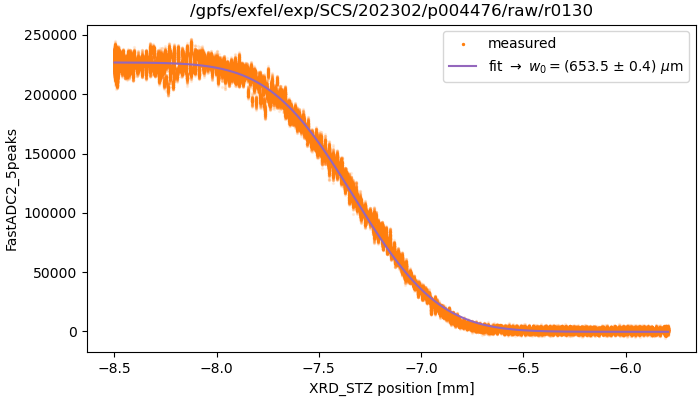

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (653.5 +/- 0.4) um
x0 = (-7.327 +/- 0.000) mm
a = 1.135880e+05 +/- 1.950313e+01 
b = -3.857367e+02 +/- 2.580742e+01 


In [2]:
proposal = 4476
runNB = 130
fields = ['XRD_STZ', 'FastADC2_5raw']
run, ds = tb.load(proposal, runNB, fields, fadc2_bp='scs_ppl')

w0_x = tb.knife_edge(ds, axisKey='XRD_STZ',
                     signalKey='FastADC2_5peaks', plot=True)[0]

### OL power measurement and fluence calibration

<IPython.core.display.Javascript object>


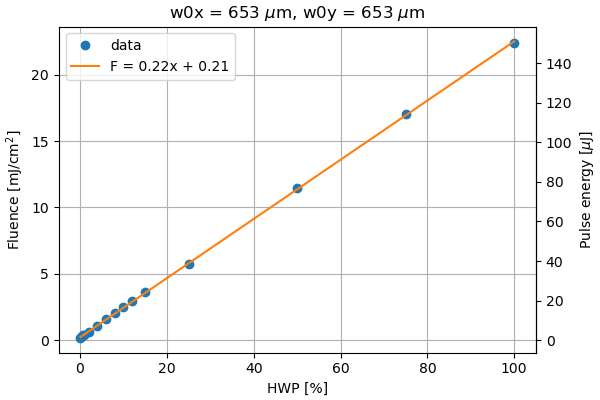

In [3]:
# the following two arrays comes from laser power measurement
rel_powers = np.array([100, 75, 50, 25, 15, 12, 10, 8, 6, 4, 2, 1, 0.75, 0.5, 0.25, 0.1])
power_mW = np.array([505, 384, 258, 130, 81, 67, 56.5, 45.8, 35.6, 24.1, 14.1, 9.3, 8.0, 6.5, 4.8, 4.1]) #in mW
npulses = 336
# Here we assume that w0y = w0x
F, F_fit, E, E_fit = tb.fluenceCalibration(rel_powers, power_mW, npulses,
                                           w0x=w0_x*1e-3, fit_order=1)

### Beam size versus scanning parameter (focus lens position, KB bending, ...)

In [4]:
proposal = 900291
runList = range(9, 16)
fields = ['chem_Y', 'HFM_BENDING', 'VFM_BENDING', 'FastADC9raw']
data = {}
for runNB in runList:
    run, ds = tb.load(proposal, runNB, fields, fadc_bp='sase3')
    data[runNB] = ds

chem_Y: only 70.3% of trains (4650 out of 6618) contain data.
HFM_BENDING: only 52.9% of trains (3499 out of 6618) contain data.
VFM_BENDING: only 52.9% of trains (3499 out of 6618) contain data.
FastADC9raw: only 12.9% of trains (852 out of 6618) contain data.
chem_Y: only 76.6% of trains (4748 out of 6201) contain data.
HFM_BENDING: only 52.8% of trains (3273 out of 6201) contain data.
VFM_BENDING: only 52.8% of trains (3273 out of 6201) contain data.
FastADC9raw: only 16.3% of trains (1011 out of 6201) contain data.
chem_Y: only 91.7% of trains (5284 out of 5762) contain data.
HFM_BENDING: only 52.9% of trains (3046 out of 5762) contain data.
VFM_BENDING: only 52.9% of trains (3046 out of 5762) contain data.
FastADC9raw: only 25.3% of trains (1458 out of 5762) contain data.
HFM_BENDING: only 53.1% of trains (3073 out of 5791) contain data.
VFM_BENDING: only 53.1% of trains (3073 out of 5791) contain data.
FastADC9raw: only 29.3% of trains (1698 out of 5791) contain data.
chem_Y: onl

In [5]:
w0_vs_bender = []
for runNB, ds in data.items():
    w0 = tb.knife_edge(ds, signalKey='FastADC9peaks', axisKey='chem_Y')[0]
    w0_vs_bender.append([ds['VFM_BENDING'].mean().values, w0])
w0_vs_bender = np.array(w0_vs_bender)

<IPython.core.display.Javascript object>


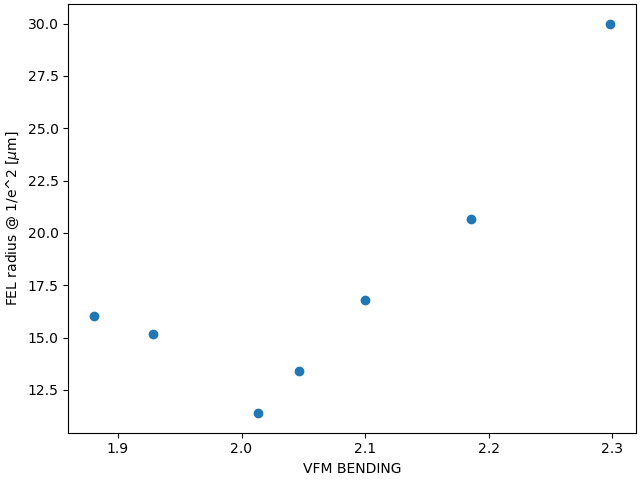

Text(0.5, 0, 'VFM BENDING')

In [6]:
plt.figure()
plt.plot(w0_vs_bender[:,0], w0_vs_bender[:, 1]*1e3, 'o')
plt.ylabel('FEL radius @ 1/e^2 [$\mu$m]')
plt.xlabel('VFM BENDING')

# Detailed notebook

## Peak fluence calculation using knife-edge scans:


The peak fluence of a Gaussian beam is defined as:

$F_0 = \frac{2 E_P}{\pi w_{0,x} w_{0,y}}$
with $E_P$ the pulse energy, $w_{0,x}$ and $w_{0,y}$ the beam radii at $1/e^2$ in $x$ and $y$ axes, respectively.


### Demonstration
For a Gaussian beam at the waist position, the intensity distribution is defined as:

$I(x,y) = I_0 e^{\left(-\frac{2x^2}{w_{0,x}^2} -\frac{2y^2}{w_{0,y}^2}\right)}$

with $I_0$ the peak intensity of the Gaussian beam, $w_{0,x}$ and $w_{0,y}$ the beam radii at $1/e^2$ in $x$ and $y$ axes, respectively.

Let's consider a knife-edge "corner" at position $(x,y)$ that blocks the beam for $x^\prime < x$ and $y^\prime < y$. The detected power behind the knife-edge is given by:

$P(x,y) = I_0 \int_{x}^\infty \int_{y}^\infty e^{\left(-\frac{2x^{\prime 2}}{w_{0,x}^2} -\frac{2y^{\prime 2}}{w_{0,y}^2}\right)} dx^\prime dy^\prime $

Now let's consider a purely vertical knife-edge. The power in the $y$ axis is integrated from $-\infty$ to $\infty$, thus:

$P(x) = I_0 \sqrt\frac{\pi}{2}w_{0,y}\int_x^\infty e^{\left(-\frac{2x^{\prime 2}}{w_{0,x}^2}\right)}dx^\prime$.

Similarly, for a purely horizontal knife-edge:

$P(y) = I_0 \sqrt\frac{\pi}{2}w_{0,x}\int_y^\infty e^{\left(-\frac{2y^{\prime 2}}{w_{0,y}^2}\right)}dy^\prime$

By fitting the knife edge scans to these functions, we extract the waist in $x$ and $y$ axes.

The total power of one pulse is then:

$P_{TOT} = \frac{I_0 \pi w_{0,x} w_{0,y}}{2}$

Hence, the peak fluence, defined as $F_0=I_0\tau$ with $\tau$ the pulse duration of the laser, is given as:

$F_0 = \frac{2 E_P}{\pi w_{0,x} w_{0,y}}$

where $E_P$ is the pulse energy.


## Optical laser beam profile and fluence

### Knife-edge measurement (OL)

#### Load scanning motor and laser photodiode data

The laser used in these knife-edge scans was the SCS backup laser, for which there was no bunch pattern table, so, whenever a function needs the bunch pattern as input argument, we set it to **'None'**. If the PP laser is used, then the corresponding bunch pattern key is **'scs_ppl'**.

In [7]:
proposal = 900094
runNB = 384
fields = ["FastADC4raw", "scannerX"]
runX, dsX = tb.load(proposal, runNB, fields, laser_bp='None')

fields = ["FastADC4raw", "scannerY"]
runNB = 385
runY, dsY = tb.load(proposal, runNB, fields, laser_bp='None')


FastADC4raw: only 94.1% of trains (768 out of 816) contain data.


#### Check diode traces and region of integration for peak calculations

Using **'show_all=True'** displays the entire trace and all integration regions. We can then zoom and pan in the interactive figure.

Auto-find peak params: 118 pulses, 324 samples between two pulses


<IPython.core.display.Javascript object>


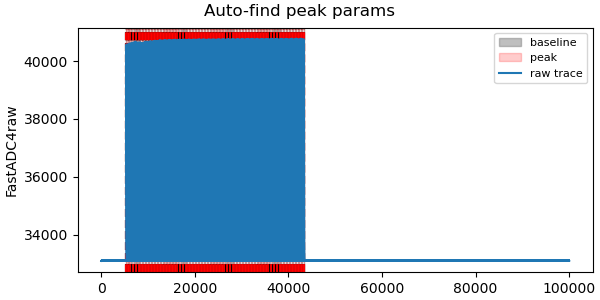

{'pulseStart': 5393, 'pulseStop': 5424, 'baseStart': 5371, 'baseStop': 5387, 'period': 324, 'npulses': 118}


In [8]:
paramsX = tb.check_peak_params(runX, 'FastADC4raw', show_all=True, bunchPattern='None')
print(paramsX)

using the default **'show_all=False'** parameter only shows the first and last pulses of the trace

Auto-find peak params: 118 pulses, 324 samples between two pulses


<IPython.core.display.Javascript object>


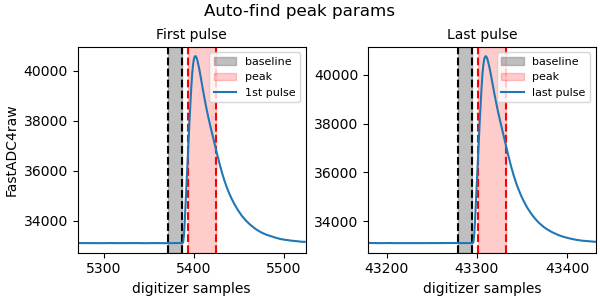

{'pulseStart': 5393,
 'pulseStop': 5424,
 'baseStart': 5371,
 'baseStop': 5387,
 'period': 324,
 'npulses': 118}

In [9]:
tb.check_peak_params(runX, 'FastADC4raw', bunchPattern='None')

#### Plot intensity vs. knife-edge positions, fit with erfc function

<IPython.core.display.Javascript object>


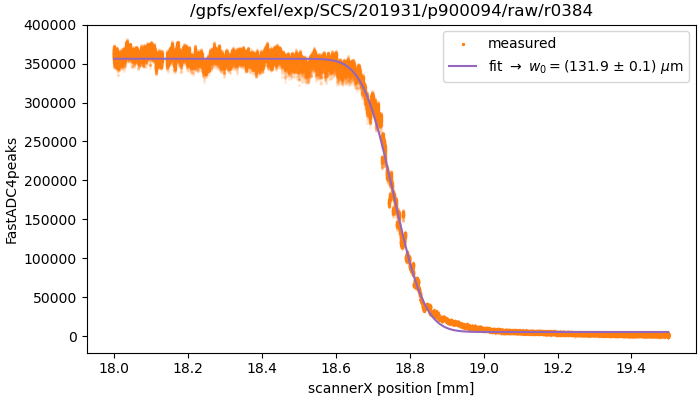

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (131.9 +/- 0.1) um
x0 = (18.757 +/- 0.000) mm
a = 1.752229e+05 +/- 2.642387e+01 
b = 5.670915e+03 +/- 3.665072e+01 


<IPython.core.display.Javascript object>


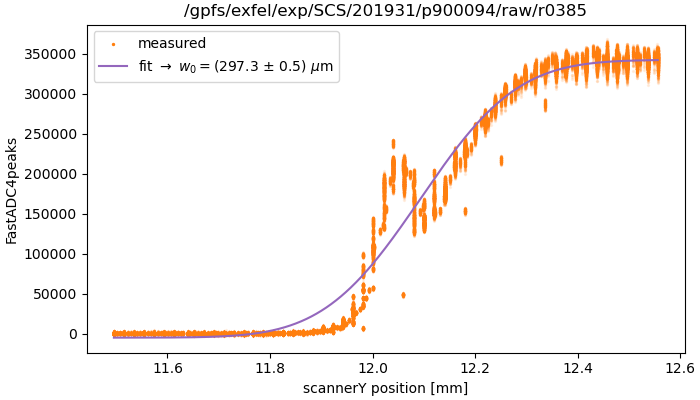

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (297.3 +/- 0.5) um
x0 = (12.093 +/- 0.000) mm
a = -1.737334e+05 +/- 1.014418e+02 
b = 3.424424e+05 +/- 1.518455e+02 
X-FWHM [um]: 155.33422804507632
Y-FWHM [um]: 350.08711535421213


In [10]:
w0_x = tb.knife_edge(dsX, axisKey='scannerX', plot=True)[0]*1e-3
w0_y = tb.knife_edge(dsY, axisKey='scannerY', plot=True)[0]*1e-3

print('X-FWHM [um]:', w0_x * np.sqrt(2*np.log(2))*1e6)
print('Y-FWHM [um]:', w0_y * np.sqrt(2*np.log(2))*1e6)

### Fluence calculation (OL)

#### OL power measurement 

In [11]:
#measurement performed in Exp Hutch before in-coupling window
rel_powers = np.array([100, 75, 50, 25, 15, 12, 10, 8, 6, 4, 2, 1, 0.75, 0.5, 0.25, 0.1])
power_mW = np.array([505, 384, 258, 130, 81, 67, 56.5, 45.8, 35.6, 24.1, 14.1, 9.3, 8.0, 6.5, 4.8, 4.1]) #in mW
npulses = 336


#### Fluence vs. laser power

Note that it is possible to change the polynomial order of the fit (for example to 2), which is useful if the output is SHG (400 nm) or THG (266 nm) but the power control is changing the 800 nm pump before conversion.

<IPython.core.display.Javascript object>


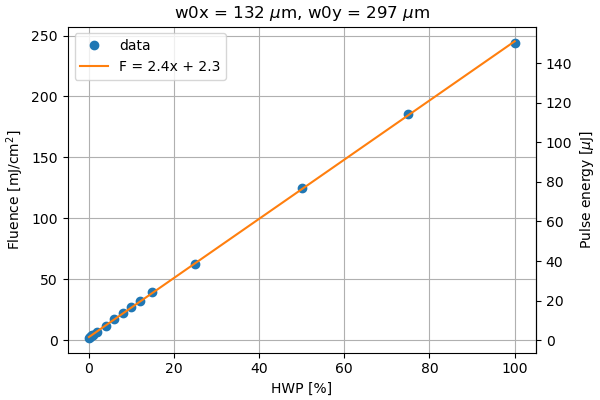

In [12]:
F, F_fit, E, E_fit = tb.fluenceCalibration(rel_powers, power_mW, npulses,
                                           w0x=w0_x, w0y=w0_y, fit_order=1)

## X-ray beam profile and fluence

### Knife-edge measurement

#### Load runs with horizontal and vertical scans, normalize the transmitted signal by XGM

In [13]:
proposal = 900094
fields = ["MCP2apd", "scannerX", "SCS_SA3"]
runNB = 687
runX, dsX = tb.load(proposal, runNB, fields)
#normalization by XGM fast signal
dsX['Tr'] = -dsX['MCP2peaks'] / dsX['SCS_SA3']

fields = ["MCP2apd", "scannerY", "SCS_SA3"]
runNB = 688
runY, dsY = tb.load(proposal, runNB, fields)
#normalization by XGM fast signal
dsY['Tr'] = -dsY['MCP2peaks'] / dsY['SCS_SA3']

dsY

<xarray.Dataset>
Dimensions:            (trainId: 808, sa3_pId: 25, pulse_slot: 2700)
Coordinates:
  * trainId            (trainId) uint64 566591561 566591562 ... 566592369
  * sa3_pId            (sa3_pId) int64 322 338 354 370 386 ... 658 674 690 706
Dimensions without coordinates: pulse_slot
Data variables:
    scannerY           (trainId) float32 14.13 14.13 14.13 ... 12.41 12.41 12.6
    MCP2peaks          (trainId, sa3_pId) float64 -3.976e+03 ... -13.49
    bunchPatternTable  (trainId, pulse_slot) uint32 2146089 0 2097193 ... 0 0 0
    SCS_SA3            (trainId, sa3_pId) float32 2.784e+03 ... 4.811e+03
    Tr                 (trainId, sa3_pId) float64 1.428 1.226 ... 0.002804
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/201931/p900094/raw/r0688

#### Fit scan to erfc function and plot

<IPython.core.display.Javascript object>


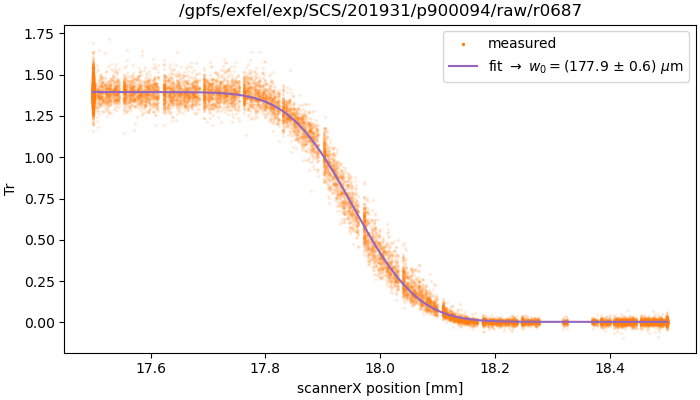

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (177.9 +/- 0.6) um
x0 = (17.953 +/- 0.000) mm
a = 6.956484e-01 +/- 5.093209e-04 
b = 3.562529e-03 +/- 7.279907e-04 


<IPython.core.display.Javascript object>


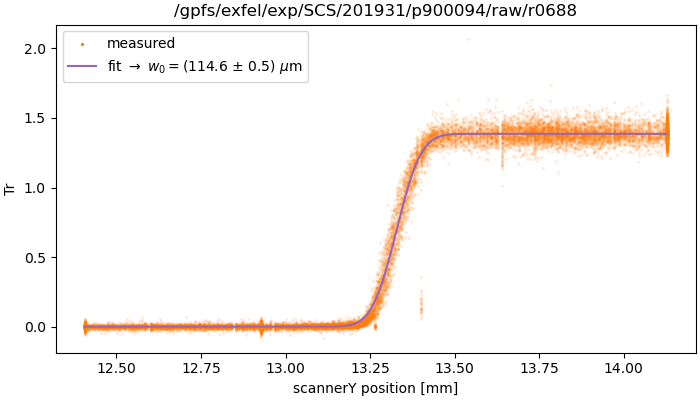

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (114.6 +/- 0.5) um
x0 = (13.328 +/- 0.000) mm
a = -6.919485e-01 +/- 4.776717e-04 
b = 1.385036e+00 +/- 7.320520e-04 
0.00017787613683544284 0.00011464177548822842
X-FWHM [um]: 209.4331462763844
Y-FWHM [um]: 134.98037545880902


In [14]:
w0_x = tb.knife_edge(dsX, axisKey='scannerX', signalKey='Tr', plot=True)[0]*1e-3
w0_y = tb.knife_edge(dsY, axisKey='scannerY', signalKey='Tr', plot=True)[0]*1e-3
print(w0_x, w0_y)

print('X-FWHM [um]:', w0_x * np.sqrt(2*np.log(2))*1e6)
print('Y-FWHM [um]:', w0_y * np.sqrt(2*np.log(2))*1e6)

### Fluence calculation

#### Load XGM data

In [15]:
proposal = 900094
runNB = 647
run, ds = tb.load(proposal, runNB, 'SCS_SA3')
ds

<xarray.Dataset>
Dimensions:            (trainId: 3095, pulse_slot: 2700, sa3_pId: 25)
Coordinates:
  * trainId            (trainId) uint64 566392087 566392088 ... 566395181
  * sa3_pId            (sa3_pId) int64 322 338 354 370 386 ... 658 674 690 706
Dimensions without coordinates: pulse_slot
Data variables:
    bunchPatternTable  (trainId, pulse_slot) uint32 2113321 0 2097193 ... 0 0 0
    SCS_SA3            (trainId, sa3_pId) float32 1.165e+04 ... 7.357e+03
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/201931/p900094/raw/r0647

#### Calibrate XGM fast data using photon flux and plot

<IPython.core.display.Javascript object>


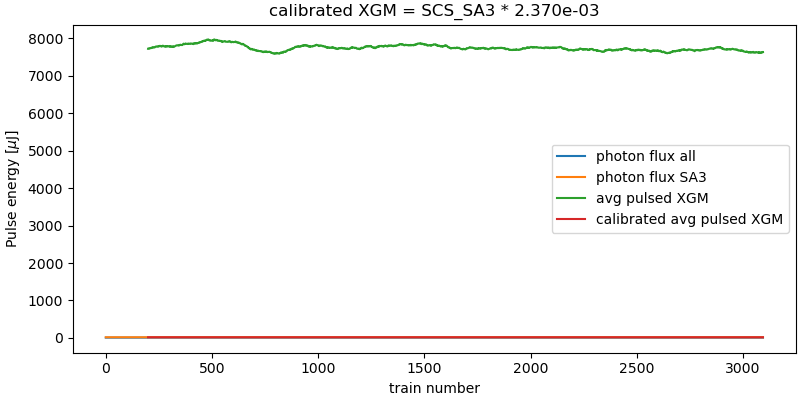

Pulse energy [J]: 1.8343257904052732e-05
Fluence [mJ/cm^2]: 57.26588845276785


<IPython.core.display.Javascript object>


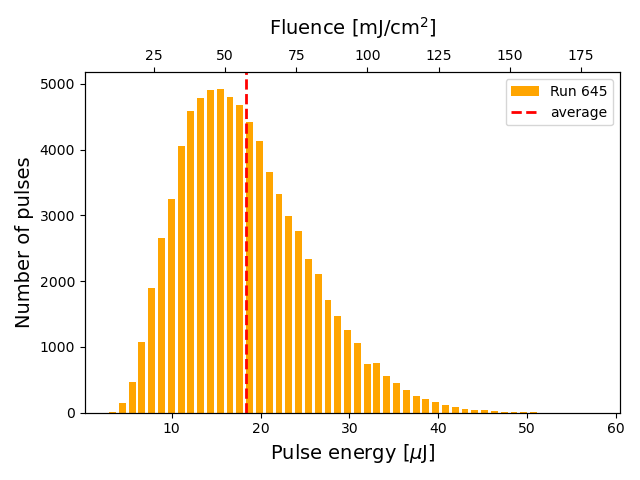

In [16]:
f_scs = tb.calibrate_xgm(run, ds, plot=True)
f_xtd10 = tb.calibrate_xgm(run, ds, xgm='SCS')

pulse_energy = ds['SCS_SA3'].mean().values*f_scs*1e-6 #average energy in J
ds['pulse_energy'] = ds['SCS_SA3']*f_scs*1e-6
ds['fluence'] = 2*ds['pulse_energy']/(np.pi*w0_x*w0_y)
print('Pulse energy [J]:',pulse_energy)
F0 = 2*pulse_energy/(np.pi*w0_x*w0_y)
print('Fluence [mJ/cm^2]:', F0*1e-1)

plt.figure()
plt.hist(ds['pulse_energy'].values.flatten()*1e6,
         bins=50, rwidth=0.7, color='orange', label='Run 645')
plt.axvline(pulse_energy*1e6, color='r', lw=2, ls='--', label='average')
plt.xlabel('Pulse energy [$\mu$J]', size=14)
plt.ylabel('Number of pulses', size=14)
plt.legend()
ax = plt.gca()
plt.twiny()
plt.xlim(np.array(ax.get_xlim())*2e-6/(np.pi*w0_x*w0_y)*1e-1)
plt.xlabel('Fluence [mJ/cm$^2$]', labelpad=10, size=14)
plt.tight_layout()